In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import Counter

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc

In [2]:
df = pd.read_csv('PCOS.csv')

df.columns = ['time','diagnosed','result','age','overweight','weightgain','periods','conceiving','chinHair','cheeksHair',
              'upperLipHair','betweenBreastHair','armsHair','innerThighHair','acneOrskinTag','hairThinning','darkPatch',
              'tiredness','moodSwings','exercise','eatOutside','cannedFood','city']

data = pd.DataFrame(df[df.diagnosed == 'Yes'])
data.reset_index(drop = True, inplace = True)
data.drop('time', axis = 1, inplace = True)
data.weightgain.fillna('abc', inplace = True)

In [3]:
def g(s):
    if (s == 'Yes'):
        return 1
    if (s == 'No'):
        return 0
    if (s == 'YES'):
        return 1
    if (s == 'NO'):
        return 0
    if (s == 'abc'):
        return 2

data['Diagnosed'] = data.diagnosed.apply(g)
data['Overweight'] = data.overweight.apply(g)
data['Weightgain'] = data.weightgain.apply(g)
data['Periods'] = data.periods.apply(g)
data['Conceiving'] = data.conceiving.apply(g)
data['AcneOrskinTag'] = data.acneOrskinTag.apply(g)
data['HairThinning'] = data.hairThinning.apply(g)
data['DarkPatch'] = data.darkPatch.apply(g)
data['Tiredness'] = data.tiredness.apply(g)
data['MoodSwings'] = data.moodSwings.apply(g)
data['CannedFood'] = data.cannedFood.apply(g)
data['City'] = data.city.apply(g)

del data['diagnosed']
del data['overweight']
del data['weightgain']
del data['periods']
del data['conceiving']
del data['acneOrskinTag']
del data['hairThinning']
del data['darkPatch']
del data['tiredness']
del data['moodSwings']
del data['cannedFood']
del data['city']

In [4]:
data['result'] = data['result'].map({'Yes': 1, 'No': 0, 'Yes(Detected Positive)': 1, 'No(Detected Negative)': 0})

X = data.drop(labels = ["result"],axis = 1)
y = data.result

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [5]:
from joblib import load

In [6]:
ada_clf = load('./savedModels/adaBoost.sav')
gb_clf = load('./savedModels/gradBoost.sav')
xgb_clf = load('./savedModels/xgBoost.sav')
cat_clf = load('./savedModels/catBoostJoblib.sav')

In [7]:
from scipy import stats

pred_ada = ada_clf.predict(X_test)
pred_gb = gb_clf.predict(X_test)
pred_xgb = xgb_clf.predict(X_test)
pred_cat = cat_clf.predict(X_test)

final_pred = np.array([])
for i in range(0,len(X_test)):
    final_pred = np.append(final_pred, stats.mode([pred_ada[i], pred_gb[i], pred_xgb[i], pred_cat[i]]))

In [8]:
ada_prob_y_pred = ada_clf.predict_proba(X_test)
gb_prob_y_pred = gb_clf.predict_proba(X_test)
xgb_prob_y_pred = xgb_clf.predict_proba(X_test)
cat_prob_y_pred = cat_clf.predict_proba(X_test)

In [9]:
ada_fpr, ada_tpr, ada_threshold = roc_curve(y_test, ada_prob_y_pred[:,1])
ada_auc = auc(ada_fpr, ada_tpr)

gb_fpr, gb_tpr, gb_threshold = roc_curve(y_test, gb_prob_y_pred[:,1])
gb_auc = auc(gb_fpr, gb_tpr)

xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_test, xgb_prob_y_pred[:,1])
xgb_auc = auc(xgb_fpr, xgb_tpr)

cat_fpr, cat_tpr, cat_threshold = roc_curve(y_test, cat_prob_y_pred[:,1])
cat_auc = auc(cat_fpr, cat_tpr)

[]

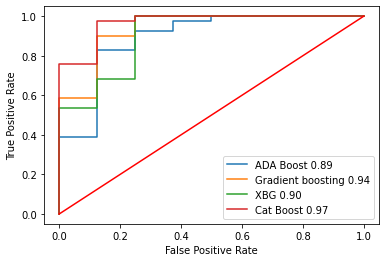

In [10]:
plt.figure()

plt.plot(ada_fpr, ada_tpr, label = 'ADA Boost %0.2f'%ada_auc)
plt.plot(gb_fpr, gb_tpr, label = 'Gradient boosting %0.2f'%gb_auc)
plt.plot(xgb_fpr, xgb_tpr, label = 'XBG %0.2f'%xgb_auc)
plt.plot(cat_fpr, cat_tpr, label = 'Cat Boost %0.2f'%cat_auc)

plt.plot([0,1],[0,1],'r-')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot()

In [11]:
ada_fpr

array([0.   , 0.   , 0.   , 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.25 , 0.25 , 0.375, 0.375, 0.5  , 0.5  , 1.   ])

In [12]:
gb_fpr

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.125, 0.125, 0.125, 0.125, 0.25 , 0.25 , 0.25 , 1.   ])

In [13]:
xgb_fpr

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.125,
       0.125, 0.25 , 0.25 , 1.   ])

In [14]:
ada = pd.DataFrame({'fpr':ada_fpr, 'tpr':ada_tpr})
ada.to_csv('./plots/adaroc.csv')

In [15]:
gb = pd.DataFrame({'fpr':gb_fpr, 'tpr':gb_tpr})
gb.to_csv('./plots/gbroc.csv')

In [16]:
xgb = pd.DataFrame({'fpr':xgb_fpr, 'tpr':xgb_tpr})
xgb.to_csv('./plots/xgbroc.csv')

In [17]:
cat = pd.DataFrame({'fpr':cat_fpr, 'tpr':cat_tpr})
cat.to_csv('./plots/catroc.csv')